# San Francisco Salary Classification

## Nathan Dorsey and Jon Davidson

## About the Data

For this analysis, we were tasked with using a dataset with hundred of thousands of entries or gigabytes in size. The dataset we chose contains approximately 150,000 entries, measuring all metrics surrounding government workers in San Francisco. Our goal was to use K-Means clustering to uncover any unusual trends based on total pay and employment status (full-time or part-time).

## Importing Libraries

Standard practice for these analyses are the packages we choose to load in. Pandas is used for data manipulation. NumPy serves as a fundamental package for computing operations. Matplotlib is used for creating visualizations. Seaborn can provide more complex visualizations. Warnings to ensure clean outputs and psutil to monitor effective use of memory when choosing to chunk data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import psutil

## Loading Data

To load the dataset efficiently, we used chunking, which splits large datasets into smaller more manageable parts. Since the dataset has 148,654 observations, we decided to break it into 8 chunks, each with about 18,581 rows. This helps ease the memory load by processing smaller portions at a time, which is helpful when working with big datasets on machines with limited RAM. By doing this, we reduced the chances of overloading memory while keeping things running smoothly. We loaded each chunk, calculating the sum of the 'TotalPay' column for each, and then combined everything into a single dataframe. To compare, I also loaded the entire dataset at once to see how memory usage differed. In the end, chunking required significantly less memory, reducing usage from 74.18 MB to 27.58 MB.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#Start tracking memory usage
memory_timestep_1 = psutil.virtual_memory()

# Load in data in chunk (8 chunks)
data_iterator = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Salaries.csv", chunksize=18581)

#Initialize salary total
total_salary_sum = 0

#Store chunks to combine for DF
chunks_list = []

for data_chunk in data_iterator:
    # Add Salary total from each chunk
    total_salary_sum += data_chunk['TotalPay'].sum()
    # Append chunk to list
    chunks_list.append(data_chunk)

#Combine all chunks
df_combined = pd.concat(chunks_list, ignore_index=True)

#Get memory used
memory_timestep_2 = psutil.virtual_memory()

# Calculate memory
memory_used_pd = (memory_timestep_2[3] - memory_timestep_1[3])/(1024*1024)
print("Memory used with chunking the dataframe: %.4f MB" % memory_used_pd)

# Track memory
memory_timestep_3 = psutil.virtual_memory()

# Load the entire dataset w/o chunking
training_data_pd = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Salaries.csv")
total_salary_sum_pd = training_data_pd['TotalPay'].sum()

# Get memory usage
memory_timestep_4 = psutil.virtual_memory()

# Memory used for loading the full dataset
memory_used_full = (memory_timestep_4[3] - memory_timestep_3[3])/(1024*1024)
print("Memory used without chunking the dataframe: %.4f MB" % memory_used_full)

Mounted at /content/drive
Memory used with chunking the dataframe: 27.1289 MB
Memory used without chunking the dataframe: 29.7812 MB


## Data Cleaning and Preprocessing

In this section, we focused on cleaning the dataset by first eliminating any rows where either EmployeeName or Job Title was recorded as "Not Provided," since these entries wouldn't add value to the analysis. We then examined the unique values in the Agency column to identify if any cities in Greater San Francisco were mentioned, although we ultimately decided to remove the Agency and Notes columns altogether. The Agency column wasn't relevant as all recording were "San Francisco" and work performance, recorded in the Notes column, was too difficult to measure effectively. We also dropped the Id column because it was redundant, as the row numbers already served as identifiers. Finally, we cleaned up missing data in the BasePay and Benefits columns by filling any null values with zeros to ensure they wouldn't interfere with the usable data. We dropped the EmployeeName column after removing NAs to avoid interference when producing models.

In [ ]:
#Eliminate rows where EmployeeName or JobTitle is not recorded
print(df_combined.tail())
print(df_combined.isna().sum())

#Eliminate all observations with Not Provided in EmployeeName and JobTitle
df_combined = df_combined[df_combined['EmployeeName'] != 'Not provided']
df_combined = df_combined[df_combined['JobTitle'] != 'Not provided']

#Find unique values in Agency column
print(df_combined['Agency'].unique())

#Eliminate Notes and Agency
df_combined = df_combined.drop(['Notes', 'Agency'], axis=1)

#Eliminate Id column
df_combined = df_combined.drop(['Id'], axis=1)

#Make N/As / Nulls into zeros
df_combined['BasePay'] = df_combined['BasePay'].fillna(0)
df_combined['Benefits'] = df_combined['Benefits'].fillna(0)

            Id   EmployeeName                    JobTitle       BasePay  \
148649  148650  Roy I Tillery                   Custodian          0.00   
148650  148651   Not provided                Not provided  Not Provided   
148651  148652   Not provided                Not provided  Not Provided   
148652  148653   Not provided                Not provided  Not Provided   
148653  148654      Joe Lopez  Counselor, Log Cabin Ranch          0.00   

         OvertimePay      OtherPay      Benefits  TotalPay  TotalPayBenefits  \
148649          0.00          0.00          0.00      0.00              0.00   
148650  Not Provided  Not Provided  Not Provided      0.00              0.00   
148651  Not Provided  Not Provided  Not Provided      0.00              0.00   
148652  Not Provided  Not Provided  Not Provided      0.00              0.00   
148653          0.00       -618.13          0.00   -618.13           -618.13   

        Year  Notes         Agency Status  
148649  2014    NaN  San

Since the data recorded all salaries from 2011 to 2014, people continue to work through that period will appear more than once. Attempting to combine all columns to get a representative dataset across years wouldn't not work as Department and Status varies immensely across these years. Therefore, we have to choose one year, where duplicates don't exist in order to analyze the year with the most data, which is 2014.

In [ ]:
yr2011 = df_combined[df_combined['Year'] == 2011].shape[0]
yr2012 = df_combined[df_combined['Year'] == 2012].shape[0]
yr2013 = df_combined[df_combined['Year'] == 2013].shape[0]
yr2014 = df_combined[df_combined['Year'] == 2014].shape[0]

# Print total observations for years
print(f"Year 2011: {yr2011}")
print(f"Year 2012: {yr2012}")
print(f"Year 2013: {yr2013}")
print(f"Year 2014: {yr2014}")

#Drop Years 2011 to 2013
df_combined = df_combined[df_combined['Year'] != 2011]
df_combined = df_combined[df_combined['Year'] != 2012]
df_combined = df_combined[df_combined['Year'] != 2013]

#Print totals after reduction
print(df_combined.shape)

Year 2011: 36159
Year 2012: 36766
Year 2013: 37606
Year 2014: 38119
(38119, 10)


## Ensure Correct Datatypes

In [ ]:
#Ensure data types
df_combined.dtypes

,0
EmployeeName,object
JobTitle,object
BasePay,object
OvertimePay,object
OtherPay,object
Benefits,object
TotalPay,float64
TotalPayBenefits,float64
Year,int64
Status,object


In this process, we aimed to optimize memory usage by converting several columns in the dataset to more efficient datatypes. We ensured BasePay, OvertimePay, OtherPay, Benefits, TotalPayBenefits, and TotalPay columns were converted to float32. This reduces the memory each value takes from 8 bytes to 4 bytes, effectively cutting memory usage in half for the columns. We also converted the Year column from int 64 to int, which requires less memory while maintaining the same data.

In [ ]:
#Convert BasePay, OvertimePay, OtherPay, Benefits to numeric datatype to reduce memory usage
df_combined['BasePay'] = df_combined['BasePay'].astype('float32')
df_combined['OvertimePay'] = df_combined['OvertimePay'].astype('float32')
df_combined['OtherPay'] = df_combined['OtherPay'].astype('float32')
df_combined['Benefits'] = df_combined['Benefits'].astype('float32')

#Convert Year from int64 to int
df_combined['Year'] = df_combined['Year'].astype('int')

#Convert TotalPay and TotalPayBenefits from float64 to float- uses more memory without purpose
df_combined['TotalPay'] = df_combined['TotalPay'].astype('float32')
df_combined['TotalPayBenefits'] = df_combined['TotalPayBenefits'].astype('float32')

#Confirm changes
print(df_combined.dtypes)

EmployeeName         object
JobTitle             object
BasePay             float32
OvertimePay         float32
OtherPay            float32
Benefits            float32
TotalPay            float32
TotalPayBenefits    float32
Year                  int64
Status               object
dtype: object


## Feature Engineering

In this section, we began by examining the format of the JobTitle column to understand how job titles were structured. After reviewing the unique values, we noticed that job titles often contained both position and department, with department typically being in parentheses, or being the last one or two words. Using that, we split the JobTitle into two columns, Position and Department. Although after later realization, we chose to drop Position as it was too difficult to assign Positions to groups versus Departments. We chose to turn the Status column binary with 1 as full-time and 0 as part-time to make it easier later.

In [ ]:
#Separate JobTitle into two columns for Position and Department
df_combined['Position'] = df_combined['JobTitle'].str.split(' ').str[0].str.strip()
df_combined['Department'] = df_combined['JobTitle'].str.split('(').str[1]
df_combined['Department'] = df_combined['Department'].str.replace(')', '', regex=False)

# Extract last word or two from JobTitle if no department is found
df_combined['Department'] = df_combined['Department'].fillna(
    df_combined['JobTitle'].apply(lambda x: x.split()[-2] if x.split()[-1].isdigit() else x.split()[-1])
)

#Drop JobTitle column
df_combined = df_combined.drop(['JobTitle'], axis=1)

#Drop Position column
df_combined = df_combined.drop(['Position'], axis=1)

#Make Status binary
df_combined['Status'] = df_combined['Status'].apply(lambda x: 1 if x == 'FT' else 0)

After further analysis of Department and Position, it was impossible to group roles and departments for an analysis, so I mapped all printed unique Departments to 10 groups, minimizing it to the best of our abilities while emphasizing rank and departments of government in one column. We saw this as the most effective way to group, even though, it might hurt the overall analysis. These groups are Law Enforcement, Public Safety, Health, Budgeting, Administration, Technician, Transport, Legal, Education, and Other.

In [ ]:
#All unique values in Department and Position
df_combined['Department'].unique()

# Remapping specific departments in 10 groups to show both rank and department
department_groups = {
  'Officer': 'Law Enforcement',
  'Police': 'Law Enforcement',
  'Sheriff': 'Law Enforcement',
  'Sergeant': 'Law Enforcement',
  'Lieutenant': 'Law Enforcement',
  'Captain': 'Law Enforcement',
  'Commander': 'Law Enforcement',
  'Investigator': 'Law Enforcement',
  'InvestigatorIII': 'Law Enforcement',
  'Insp': 'Law Enforcement',
  'Defender': 'Law Enforcement',
  'Cadet': 'Law Enforcement',
  'Undersheriff': 'Law Enforcement',
  'Sup/Invst.': 'Law Enforcement',
  'Ofcr': 'Law Enforcement',
  'Civil & Criminal': 'Law Enforcement',
  'Probation': 'Law Enforcement',
  'Invsgtn': 'Law Enforcement',
  'Examiner': 'Law Enforcement',
  'Inspector': 'Law Enforcement',
  'Inpsector': 'Law Enforcement',
  'Police Department': 'Law Enforcement',
  'Criminal': 'Law Enforcement',
  'Civil/Criminal': 'Law Enforcement',
  'Invstgtor': 'Law Enforcement',
  'Ofc': 'Law Enforcement',
  'Paramedic': 'Public Safety',
  'Fire Dept': 'Public Safety',
  'Firefighter': 'Public Safety',
  'EMT/Paramedic/Firefighter': 'Public Safety',
  'Suppress': 'Public Safety',
  'Suppression': 'Public Safety',
  'Guard': 'Public Safety',
  'Lifeguard': 'Public Safety',
  'DPH': 'Health',
  'Health': 'Health',
  'Psychiatric': 'Health',
  'Nurse': 'Health',
  'Anesthetist': 'Health',
  'Pharmacist': 'Health',
  'Toxicologist': 'Health',
  'Practitioner': 'Health',
  'Midwife': 'Health',
  'Counselor': 'Health',
  'Therapist': 'Health',
  'Dentist': 'Health',
  'Veterinarian': 'Health',
  'Hygienist': 'Health',
  'Acupuncturist': 'Health',
  'Microbiologist': 'Health',
  'Biologist': 'Health',
  'Pathologist': 'Health',
  'Psychologist': 'Health',
  'Epidemiologist': 'Health',
  'Audiometrist': 'Health',
  'Dietitian': 'Health',
  'Nutritionist': 'Health',
  'SFGH': 'Health',
  'Audiologist': 'Health',
  'Cnslr': 'Health',
  'Controller': 'Budgeting',
  'Treasurer': 'Budgeting',
  'Assessor': 'Budgeting',
  'Purchaser': 'Budgeting',
  'Benefits': 'Budgeting',
  'Auditor': 'Budgeting',
  'Appraiser': 'Budgeting',
  'Adjuster': 'Budgeting',
  'Collector': 'Budgeting',
  'Accountant': 'Budgeting',
  'Retirement': 'Budgeting',
  'Manager': 'Administration',
  'Supervisor': 'Administration',
  'Supt': 'Administration',
  'Planner': 'Administration',
  'Coordinator': 'Administration',
  'Administrator': 'Administration',
  'Director': 'Administration',
  'Assistant': 'Administration',
  'Administrator-Supervisor': 'Administration',
  'Comm': 'Administration',
  'Trainer-Senior': 'Administration',
  'Trainer-Assistant': 'Administration',
  'Coordinator': 'Administration',
  'Clerk': 'Administration',
  'Secretary': 'Administration',
  'Registrar': 'Administration',
  'Trainer-Journey': 'Administration',
  'Leader': 'Administration',
  'Advisor': 'Administration',
  'Admin': 'Administration',
  'Chief': 'Administration',
  'Department': 'Administration',
  'Employee': 'Administration',
  'Dept': 'Administration',
  'Specialist': 'Administration',
  'Mayor': 'Administration',
  'Center': 'Administration',
  'VIII': 'Administration',
  'Prev': 'Administration',
  'IV': 'Administration',
  'SFERS': 'Administration',
  'Spec': 'Administration',
  'Svcs': 'Administration',
  'III': 'Administration',
  'Div': 'Administration',
  'VII': 'Administration',
  'Sprv': 'Administration',
  'VI': 'Administration',
  'II': 'Administration',
  'XVII': 'Administration',
  'I': 'Administration',
  'Associate': 'Administration',
  'Sr': 'Administration',
  'Assoc': 'Administration',
  'Sprv1': 'Administration',
  'XVI': 'Administration',
  'XV': 'Administration',
  'Fac': 'Administration',
  'Analyst': 'Administration',
  'Analyst-Principal': 'Administration',
  'Coord': 'Administration',
  'Hall': 'Administration',
  'Supv': 'Administration',
  'Mgr': 'Administration',
  'Analyst-Senior': 'Administration',
  'XIV': 'Administration',
  'Universal': 'Administration',
  'Review': 'Administration',
  'Services': 'Administration',
  'Wrk': 'Administration',
  'XI': 'Administration',
  'XIII': 'Administration',
  'Scheduler': 'Administration',
  'Poll': 'Administration',
  'Repres': 'Administration',
  'Supervisors': 'Administration',
  'Superintendent': 'Administration',
  'Repr': 'Administration',
  'Involvement': 'Administration',
  'Rec': 'Administration',
  'Representat': 'Administration',
  'OCC': 'Administration',
  'AccessSvcs': 'Administration',
  'Cmplnts': 'Administration',
  'Aide': 'Administration',
  'Commission': 'Administration',
  'Rep': 'Administration',
  'Page': 'Administration',
  'Aide-Admin': 'Administration',
  'Works': 'Administration',
  'Intern': 'Administration',
  'Prof': 'Administration',
  'Supervisor': 'Administration',
  'Sup': 'Administration',
  'Supervis': 'Administration',
  'Conversion': 'Administration',
  'M=$200/Mtg': 'Administration',
  'Grp5,M$100/Mo': 'Administration',
  'Grp3,M=$50/Mtg': 'Administration',
  'Grp2,M=$25/Mtg': 'Administration',
  'Engineer': 'Technician',
  'Technician': 'Technician',
  'Technician-Senior': 'Technician',
  'Architect': 'Technician',
  'Machinist': 'Technician',
  'Mechanic': 'Technician',
  'Welder': 'Technician',
  'Carpenter': 'Technician',
  'Locksmith': 'Technician',
  'Plumber': 'Technician',
  'Painter': 'Technician',
  'Steamfitter': 'Technician',
  'Eng,WtrTreatPlnt': 'Technician',
  'Eng': 'Technician',
  'Engineer-Senior': 'Technician',
  'Engineer-Principal': 'Technician',
  'Engineer-Journey': 'Technician',
  'Surveyor': 'Technician',
  'Technican': 'Technician',
  'Apprentice': 'Technician',
  'Splicer': 'Technician',
  'Chemist': 'Technician',
  'Microbiologist': 'Technician',
  'Mech': 'Technician',
  'Tech': 'Technician',
  'Electrician': 'Technician',
  'Worker': 'Technician',
  'Engr': 'Technician',
  'Plnt': 'Technician',
  'Plant': 'Technician',
  'Repairer': 'Technician',
  'Cleaner': 'Technician',
  'Engineer-Assistant': 'Technician',
  'Engineer-Principal': 'Technician',
  'Engineer-Senior': 'Technician',
  'Engineer-Journey': 'Technician',
  'Helper': 'Technician',
  'Storekeeper': 'Technician',
  'Forester': 'Technician',
  'Laborer': 'Technician',
  'Bricklayer': 'Technician',
  'Glazier': 'Technician',
  'Environ': 'Technician',
  'Mason': 'Technician',
  'Maker': 'Technician',
  'Groundskpr': 'Technician',
  'Signs': 'Technician',
  'Spc': 'Technician',
  'Designer': 'Technician',
  'Specialst': 'Technician',
  'Anl': 'Technician',
  'Meas': 'Technician',
  'Keeper': 'Technician',
  'Roofer': 'Technician',
  'Typist': 'Technician',
  'Analyst-Assistant': 'Technician',
  'Hodcarrier': 'Technician',
  'Gardener': 'Technician',
  'Metalsmith': 'Technician',
  'Finisher': 'Technician',
  'Custodian': 'Technician',
  'Coverer': 'Technician',
  'Preparator': 'Technician',
  'Setter': 'Technician',
  'Assist': 'Technician',
  'Wrkr': 'Technician',
  'Trainee': 'Technician',
  'Operator-Senior': 'Technician',
  'Asst': 'Technician',
  'Tech.': 'Technician',
  'Farmer': 'Technician',
  'Clnr': 'Technician',
  'Train2/Arch/Eng/Plng': 'Technician',
  'Arch/Eng/Plng': 'Technician',
  'Analyst-Assistant': 'Technician',
  'Operator-Journey': 'Technician',
  'Statistician': 'Technician',
  'MTA': 'Transport',
  'SFMTA': 'Transport',
  'Railway': 'Transport',
  'Operator': 'Transport',
  'Dispatcher': 'Transport',
  'Driver': 'Transport',
  'Porter': 'Transport',
  'Checker': 'Transport',
  'Disp': 'Transport',
  'Boats': 'Transport',
  'Wharfinger': 'Transport',
  'Port': 'Transport',
  'Attorney': 'Legal',
  'Atty': 'Legal',
  'Defender': 'Legal',
  'Court': 'Legal',
  'Civil & Criminal': 'Legal',
  'Probation': 'Legal',
  'Court': 'Legal',
  'Prob': 'Legal',
  'Cvl&Crmnl': 'Legal',
  'Principal': 'Education',
  'Instructor': 'Education',
  'Librarian': 'Education',
  'Educator': 'Education',
  'Braillist': 'Education',
  'Artist': 'Education',
  'Photographer': 'Education',
  'Curator': 'Education',
  'Arts': 'Education',
  'Ranch': 'Other',
  'Rnch': 'Other',
  'Helper': 'Other',
  'Receiver': 'Other',
  'Agent': 'Other',
  'Women': 'Other',
  'Chef': 'Other',
  'Baker': 'Other',
  'Barber': 'Other',
  'Beautician': 'Other',
  'Cook': 'Other',
  'Orderly': 'Other',
  'Attendant': 'Other',
  'Cashier': 'Other',
  'Reader': 'Other',
  'Measures': 'Other',
  'Of': 'Other',
  'I/II': 'Other',
  'Seasonal': 'Other',
  'Works': 'Other',
  'V': 'Other',
  'CA': 'Other',
  'IX': 'Other',
  'AAM': 'Other',
  'X': 'Other'
}

# Map Department to broader categories in DepartmentGroup
df_combined['DepartmentGroup'] = df_combined['Department'].map(department_groups)

# Check unmapped departments
unmapped_departments = df_combined[df_combined['DepartmentGroup'].isna()]['Department'].unique()
print("Unmapped Departments:", unmapped_departments)

Unmapped Departments: []


### Analysis

Now, we will use K-Means Clustering to group the data based on compensation and employment status (part-time or full-time).

First, we'll use the elbow method to determine the optimal number of clusters to group the data in based on the sum of squared distances between each data point and the centroid to the cluster it is in.

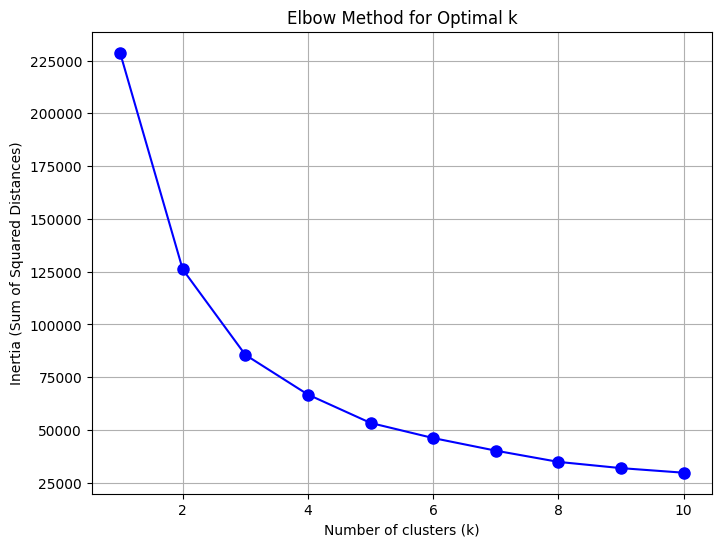

In [ ]:
numeric_columns = ['BasePay', 'OvertimePay', 'OtherPay', 'Benefits', 'TotalPay', 'TotalPayBenefits']
data_for_clustering = df_combined[numeric_columns]

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

# Use the Elbow method to find the optimal number of clusters
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

From the elbow method, we can see that about 4 clusters is the optimal number, as we start to see diminishing marginal returns from each additional cluster after that point, although the line is certainly more curved than it is angled, possibly due to the size of the dataset and number of observations and features.

First, we want to run the algorithm with the chosen value of k=4.

In [ ]:
from sklearn.cluster import KMeans

# Set the number of clusters to 4 (based on the Elbow method result)
kmeans = KMeans(n_clusters=4, random_state=42)

# Fit the KMeans model on your scaled data
kmeans.fit(scaled_data)

# Get the cluster labels for each data point
df_combined['Cluster'] = kmeans.labels_

# Display the first few rows to see the assigned cluster
df_combined.head()

,EmployeeName,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Status,Department,DepartmentGroup,Cluster
110531,David Shinn,129150.007812,0.000000,342802.625000,38780.039062,471952.62500,510732.68750,2014,0,Chief,Administration,3
110532,Amy P Hart,318835.500000,10712.950195,60563.539062,89540.226562,390111.96875,479652.21875,2014,1,Examiner,Law Enforcement,3
110533,William J Coaker Jr.,257340.000000,0.000000,82313.703125,96570.656250,339653.68750,436224.37500,2014,0,Officer,Law Enforcement,3
110534,Gregory P Suhr,307450.031250,0.000000,19266.720703,91302.460938,326716.75000,418019.21875,2014,1,Police,Law Enforcement,2
110535,Joanne M Hayes-White,302068.000000,0.000000,24165.439453,91201.656250,326233.43750,417435.09375,2014,1,Department,Administration,2


We want to analyze which features are the most important, so we will measure the centers of each cluster and then inverse the scaling we did earlier so that we can interpret the cluster centers in the original scale.

In [ ]:
# Get the cluster centers from KMeans
cluster_centers = kmeans.cluster_centers_

# Reverse the scaling to interpret cluster centers in the original scale
original_cluster_centers = scaler.inverse_transform(cluster_centers)

# Create a DataFrame to visualize the cluster centers
feature_importance_df = pd.DataFrame(original_cluster_centers, columns=numeric_columns)

We can then visualize this in a bar chart and a heat map:

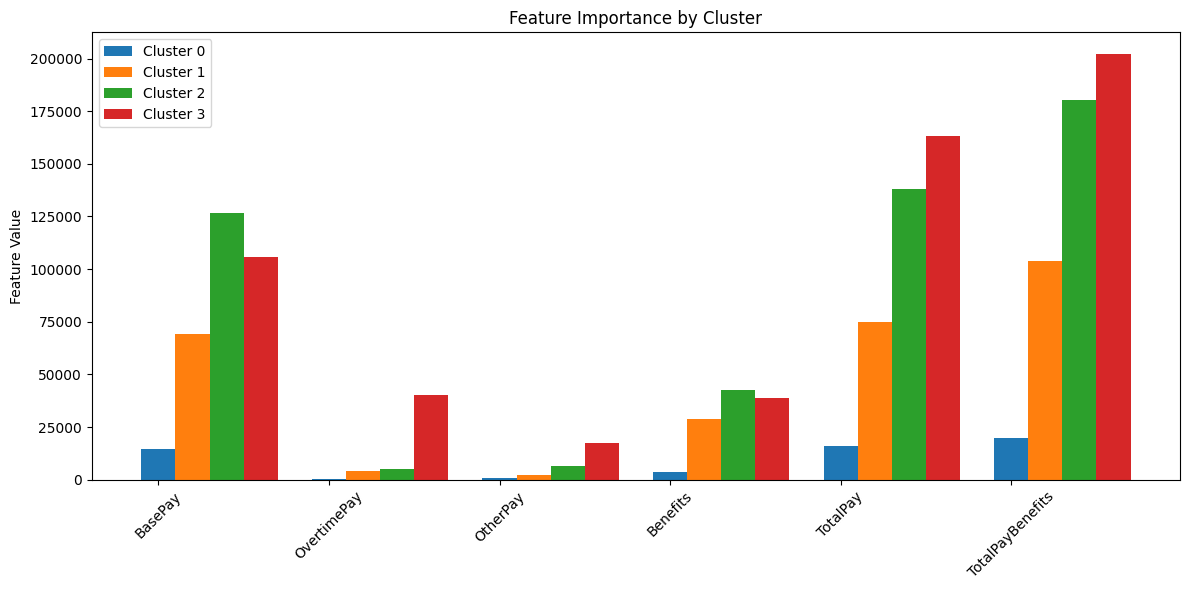

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the feature importance for each cluster
for i in range(len(cluster_centers)):
    ax.bar(np.arange(len(numeric_columns)) + i*0.2, original_cluster_centers[i], width=0.2, label=f'Cluster {i}')

# Set labels and legend
ax.set_xticks(np.arange(len(numeric_columns)))
ax.set_xticklabels(numeric_columns, rotation=45)
ax.set_ylabel('Feature Value')
ax.set_title('Feature Importance by Cluster')
ax.legend()

plt.tight_layout()
plt.show()

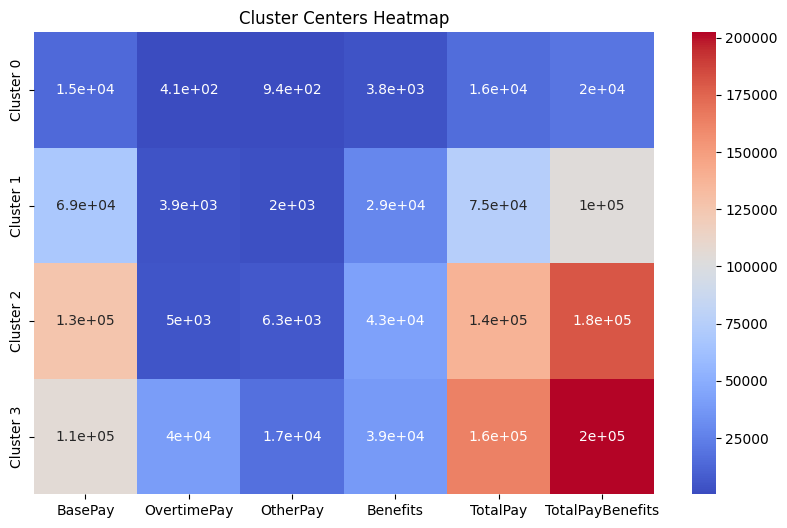

In [ ]:
import seaborn as sns

# Create a heatmap of the cluster centers
plt.figure(figsize=(10, 6))
sns.heatmap(feature_importance_df, annot=True, cmap='coolwarm', xticklabels=numeric_columns, yticklabels=[f'Cluster {i}' for i in range(len(cluster_centers))])
plt.title('Cluster Centers Heatmap')
plt.show()

We definitely can extract some insights from this, but frankly, there's a little too much information here that might be making it hard to cluster the data. We'll use PCA to reduce dimensionality and then analyze the clusters based on the principle components found in the data.

In [ ]:
from sklearn.decomposition import PCA

# Fit PCA on the scaled data
pca = PCA()

# Fit and transform the data to PCA space
pca_data = pca.fit_transform(scaled_data)

# Check explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance.cumsum()

print(f"Explained variance ratio per component: {explained_variance}")
print(f"Cumulative explained variance: {cumulative_explained_variance}")


Explained variance ratio per component: [7.05549777e-01 1.65562198e-01 1.15070276e-01 1.38177862e-02
 3.44061522e-15 6.30890733e-16]
Cumulative explained variance: [0.7055498 0.871112  0.9861823 1.        1.        1.       ]


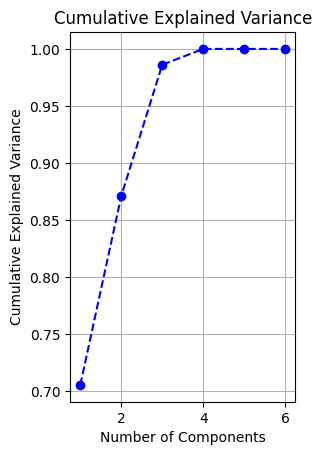

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--', color='b', label='Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.grid(True)

We can see from the above cumulative explained variance, as well as the graph visualizing it, that just 2 principal components retain almost 90% of the variance, so we'll just use two.

In [ ]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

In [ ]:
# Number of clusters K is still 4
# Fit KMeans on the PCA-transformed data
kmeans.fit(pca_data)

# Get the cluster labels for each data point
df_combined['Cluster'] = kmeans.labels_

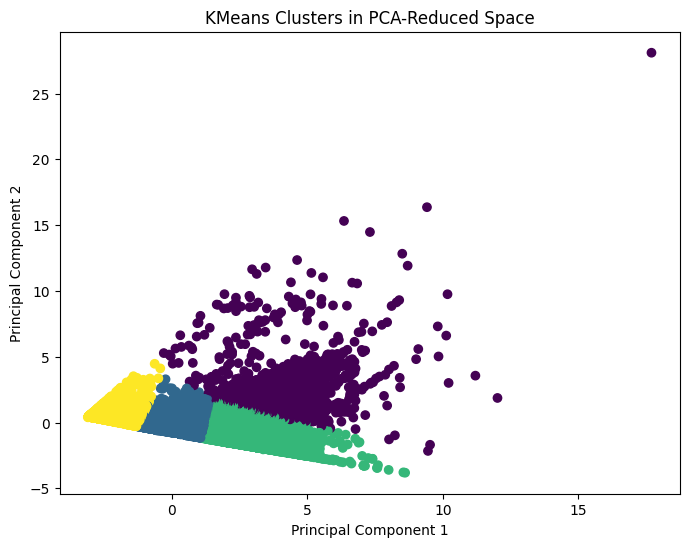

In [ ]:
# Plot the PCA-transformed data with cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=df_combined['Cluster'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clusters in PCA-Reduced Space')
plt.show()

Since we only have two clusters, it's much easier to visualize and extract information from our clustering, since we can visualize it in just two dimensions. Let's examine the characteristics of each cluster

In [ ]:
# Separate numeric and categorical columns
numeric_columns = df_combined.select_dtypes(include=['float32', 'int64']).columns
categorical_columns = df_combined.select_dtypes(include=['object']).columns

# For categorical columns, calculate the mode per cluster (drop EmployeeName)
categorical_summary = df_combined.groupby('Cluster')[categorical_columns].agg(lambda x: x.mode()[0])
# Drop 'EmployeeName' from the categorical columns
categorical_columns = categorical_columns.drop('EmployeeName')

# Calculate the categorical summary without the 'EmployeeName' column
categorical_summary = df_combined.groupby('Cluster')[categorical_columns].agg(lambda x: x.mode()[0])

# For numeric columns, calculate the mean per cluster
numeric_summary = df_combined.groupby('Cluster')[numeric_columns].mean()

# Combine the summaries
cluster_summary = pd.concat([numeric_summary, categorical_summary], axis=1)

In [ ]:
cluster_summary

,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Status,Department,DepartmentGroup
Cluster,,,,,,,,,,
0,112568.250000,37358.722656,20637.875000,40212.808594,170564.828125,210777.656250,2014.0,0.899255,Firefighter,Law Enforcement
1,68284.898438,3726.334229,2016.134644,28407.841797,74027.367188,102435.210938,2014.0,0.774266,Worker,Administration
2,122128.812500,6695.169922,5355.613770,41783.835938,134179.593750,175963.421875,2014.0,0.898104,Officer,Law Enforcement
3,14256.174805,408.339996,907.582886,3728.906982,15572.097656,19301.005859,2014.0,0.004285,Nurse,Administration


### Discussing the Clusters
#### Cluster 0: High Pay, Law Enforcement (Firefighter), Mostly Full-time
With a base pay of \$112,568 with additionally high opportunity for overtime pay, other pay, and benefits. Totaling \$210,778, this cluster likely represents fill-time workers falling under the broader `DepartmentGroup` category of Law Enforcement, while the mode `Department` is Firefighter. Due to the demanding nature of these jobs, these individuals earn a high base salary and strong compensation overall, and the mean `status` of 0.899 indicates that the majority of these individuals work full-time.

#### Cluster 1: Mid-Pay Administrative Workers, Mixed Full- and Part-Time
This cluster's mean `status` of 0.774 indicates a blend of full-time and part-time workers, favoring more full-time than part time. While base pay is decent, at $68,286, overtime and other pay opportunities are limited, suggesting a stable but slightly less well-compensated workforce in similar administrative roles. The mode `Department` is the generic "Worker", suggesting a high representation of middle management or more office-type roles.

#### Cluster 2: High Pay, Law Enforcement (Officer), Mostly Full-time
This cluster is most similar to cluster 0, but seems to more strongly represent the police force as opposed to fire department workforce, as in cluster 0. Boasting a similarly high -- even marginally higher -- base pay than cluster 0, they have a high total compensation package, with less opportunity for overtime pay compared to cluster 0, with a mean $6,694 overtime pay.The high mean `status` of 0.898, indicating a strong majority of full-time workers, aligning with expectations for such critical roles in public safety and law enforcement.

#### Cluster 3: Very Low Pay, Nurses or other Administrative Workers, Part-Time
This cluster is by far the least paid, and seems to include virtually all of the other roles not included in the other clusters. This cluster seems to include the vast majority of the part-time workforce, as it has a mean `status` of 0.004. With a base pay of \$14,256 and a total compensation package -- including benefits -- of $19,301, this cluster likely contains lots of intern-like work, with very limited hours, likely contributing greatly to such a low total compensation in comparison to the other clusters. As a whole, all of the attributes of this cluster -- role, average pay, employment status -- suggest that this cluster is made up of interns, volunteers, or individuals in situations "adjacent" to interns or volunteers, like temp or contract workers, given the general fields of administration and healthcare, low pay, and overwhelmingly part-time employment status.

## Conclusion
The K-means clustering analysis, using PCA to reduce dimensionality and aid in the ease of cluster creation and grouping, revealed distinct groups within the San Francisco public workforce which each represented unique characteristics in terms of role, employment status, and compensation, and helps highlight certain roles and values that the government of San Francisco holds in high regard as it pertains to who they hire and what they find important.  

The highest paid clusters, for example, 0 and 2, consist of mostly "Law Enforcement" roles, specifically fire department and police force roles, respectively. The high compensation and large cluster size reflects a very high demand for these roles, and suggests that there is a lot of opportunity for individuals pursuing roles in these fields for career growth and upward mobility.

Cluster 1 reflects the city's need for a stable administrative workforce carrying out essential, yet less high-risk roles for city function.  

Cluster 3, the lowest paid, part-time cluster, which likely consists of a large amount of temporary or contract workers, volunteers, or interns, highlights perhaps a more niche need within the public sector of San Francisco for flexible, more introductory roles or younger workers interested in pursuing a career in the public sector, possibly in healthcare, highlighting the city's opportunities for entry.